In [4]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [6]:
import pandas as pd
import re
import seaborn as sb

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.linear_model import LogisticRegression
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from matplotlib import pyplot as plt # for word cloud

In [7]:
df = pd.read_csv("https://cs4395.s3.us-east-2.amazonaws.com/coffee_maker.csv")
df = df.iloc[:, [2, 4]]
df

,rating,review
0,2.0,Delightful coffee maker if you’re only looking...
1,1.0,UPDATE: Bought this 10-21-18 and I finally ret...
2,4.0,The big reason I ordered this was because I wa...
3,5.0,I've owned several of their older brewstation ...
4,3.0,I agonized over which coffee maker to purchase...
...,...,...
4995,5.0,Our Mr. Coffee machine stopped working one day...
4996,1.0,This is the second generation of this product ...
4997,5.0,Wow works great and bought it for a bargain wi...
4998,2.0,Doesn’t brew correctly need to start to get al...


In [8]:
df['review'] = df['review'].str.lower() # lowercase
df['review'] = df['review'].map(lambda x: re.sub(r'[^a-zA-z0-9\s]', '', str(x))) # remove punc
df

,rating,review
0,2.0,delightful coffee maker if youre only looking ...
1,1.0,update bought this 102118 and i finally retire...
2,4.0,the big reason i ordered this was because i wa...
3,5.0,ive owned several of their older brewstation m...
4,3.0,i agonized over which coffee maker to purchase...
...,...,...
4995,5.0,our mr coffee machine stopped working one day ...
4996,1.0,this is the second generation of this product ...
4997,5.0,wow works great and bought it for a bargain wi...
4998,2.0,doesnt brew correctly need to start to get all...


In [9]:
df['rating'].value_counts()

5.0    2305
1.0    1084
4.0     631
2.0     526
3.0     454
Name: rating, dtype: int64

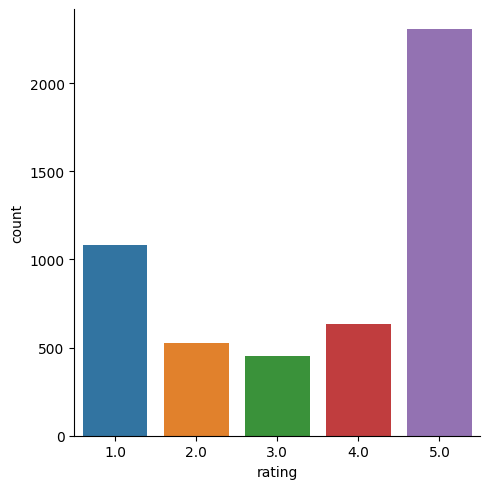

In [10]:
sb.catplot(x="rating", kind="count", data=df)

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(df['review'])

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [12]:
def get_sentiment(rating):
    if rating == 1 or rating == 2 or rating == 3:
        return 0
    if rating == 4 or rating == 5:
        return 1


df["rating"] = df["rating"].apply(get_sentiment)

In [13]:
df

,rating,review
0,0,delightful coffee maker if youre only looking ...
1,0,update bought this 102118 and i finally retire...
2,1,the big reason i ordered this was because i wa...
3,1,ive owned several of their older brewstation m...
4,0,i agonized over which coffee maker to purchase...
...,...,...
4995,1,our mr coffee machine stopped working one day ...
4996,0,this is the second generation of this product ...
4997,1,wow works great and bought it for a bargain wi...
4998,0,doesnt brew correctly need to start to get all...


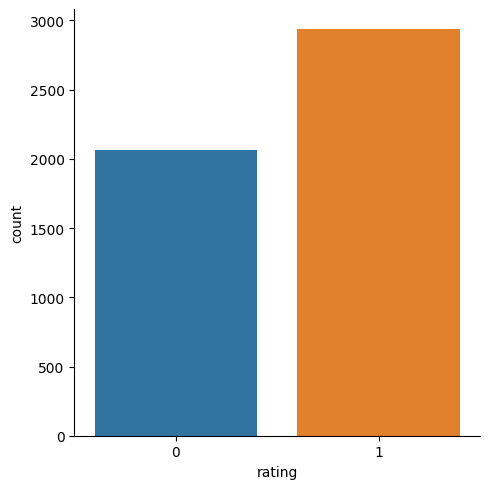

In [14]:
sb.catplot(x="rating", kind="count", data=df)

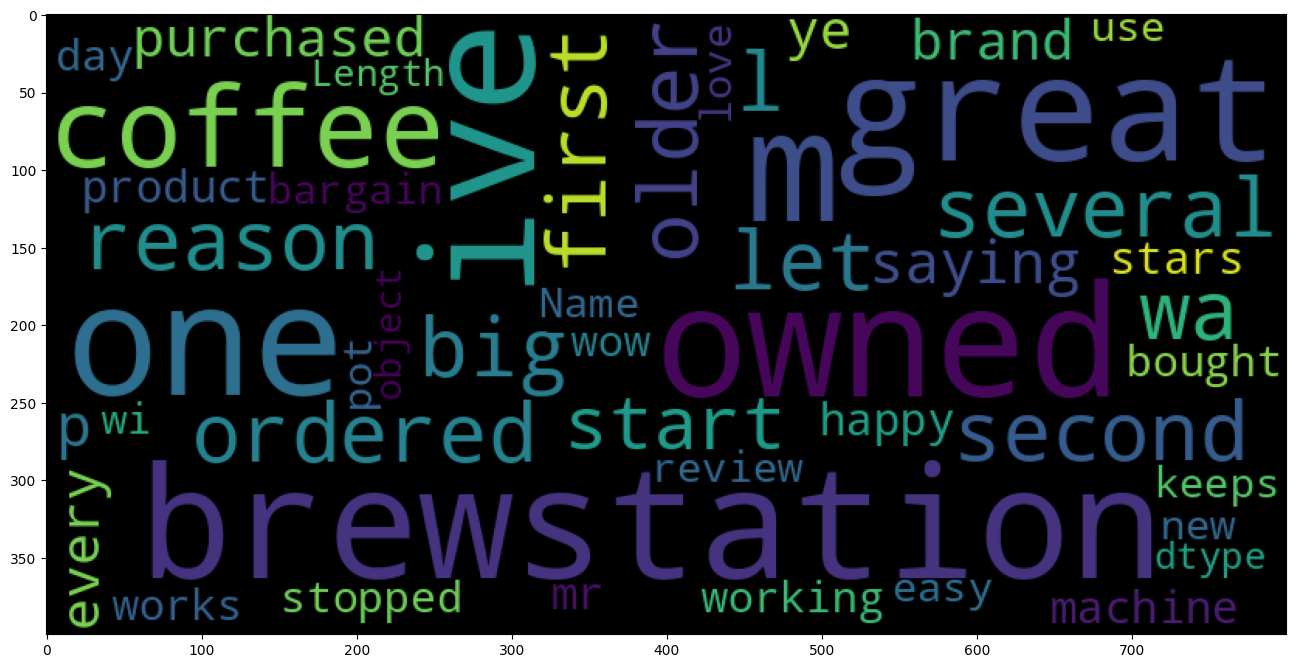

In [15]:
#pip or pip3 install wordcloud

from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(background_color='black', stopwords = STOPWORDS,
                max_words = 100, max_font_size = 100, 
                random_state = 15, width=800, height=400)

plt.figure(figsize=(16, 12))
wordcloud.generate(str(df.loc[df['rating'] == 1, 'review']))
plt.imshow(wordcloud)

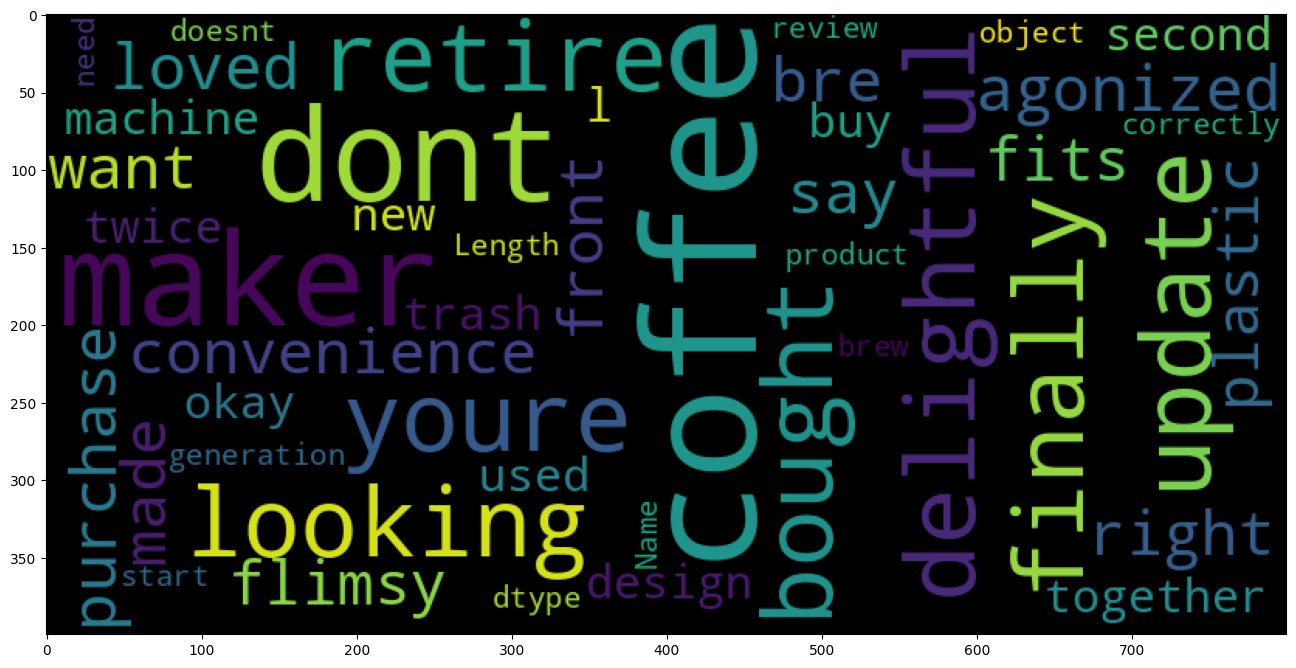

In [16]:
#pip or pip3 install wordcloud

from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(background_color='black', stopwords = STOPWORDS,
                max_words = 100, max_font_size = 100, 
                random_state = 15, width=800, height=400)

plt.figure(figsize=(16, 12))
wordcloud.generate(str(df.loc[df['rating'] == 0, 'review']))
plt.imshow(wordcloud)

In [17]:
def lemmatize_review(review):
    # Tokenize the review into words
    words = word_tokenize(review)
    # Lemmatize each word in the review and join them back into a string
    lem_words = [WordNetLemmatizer().lemmatize(word) for word in words]
    lem_review = ' '.join(lem_words)
    return lem_review

In [68]:
df['review'] = df['review'].apply(lemmatize_review)

# Naive Bayes

In [18]:
X = df['review']
Y = df['rating']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=None)

In [19]:
# tfidf vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)

X_train = vectorizer.fit_transform(X_train)  # fit and transform the train data
X_test = vectorizer.transform(X_test)        # transform only the test data

In [20]:
mnb = MultinomialNB()
mnb.fit(X_train, Y_train)

MultinomialNB()

In [21]:
pred = mnb.predict(X_test)

In [22]:
confusion_matrix(Y_test, pred)

array([[304, 107],
       [ 22, 567]])

In [23]:
accuracy_score(Y_test, pred)

0.871

In [24]:
def get_scores(Y_test, pred):
  print('accuracy score: ', accuracy_score(Y_test, pred) * 100, '%')
  print('precision score: ', precision_score(Y_test, pred) * 100, '%')
  print('recall score: ', recall_score(Y_test, pred) * 100, '%')
  print('f1 score: ', f1_score(Y_test, pred) * 100, '%')

In [25]:
def get_roc_auc(X_test, Y_test, preds_probs):
  fpr, tpr, _ = roc_curve(Y_test, preds_probs)
  print('ROC AUC: ', auc(fpr, tpr) * 100, '%')

In [26]:
# MNB
print(get_scores(Y_test, mnb.predict(X_test)))
print(get_roc_auc(X_test, Y_test, mnb.predict_proba(X_test)[:, 1]))

accuracy score:  87.1 %
precision score:  84.1246290801187 %
recall score:  96.26485568760611 %
f1 score:  89.78622327790974 %
None
ROC AUC:  95.87613960731828 %
None


In [27]:
cnb = ComplementNB()
cnb.fit(X_train, Y_train)

ComplementNB()

In [28]:
# CNB
print(get_scores(Y_test, cnb.predict(X_test)))
print(get_roc_auc(X_test, Y_test, cnb.predict_proba(X_test)[:, 1]))

accuracy score:  88.6 %
precision score:  88.49270664505673 %
recall score:  92.69949066213921 %
f1 score:  90.54726368159206 %
None
ROC AUC:  95.87613960731828 %
None


In [29]:
from sklearn.naive_bayes import BernoulliNB
BNB = BernoulliNB()
BNB.fit(X_train, Y_train)

BernoulliNB()

In [30]:
# BNB
print(get_scores(Y_test, BNB.predict(X_test)))
print(get_roc_auc(X_test, Y_test, BNB.predict_proba(X_test)[:, 1]))

accuracy score:  79.0 %
precision score:  78.15750371471026 %
recall score:  89.30390492359932 %
f1 score:  83.35974643423137 %
None
ROC AUC:  90.50495912491377 %
None


# Neural Networks

In [31]:
stopwords = set(stopwords.words('english'))
vectorizer = TfidfVectorizer(stop_words=list(stopwords), binary=True)

In [32]:
# set up X and y
X = vectorizer.fit_transform(df.review)
y = df.rating

In [34]:
from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier(solver='lbfgs', alpha=0.2, random_state=1)
classifier.fit(X_train, Y_train)

MLPClassifier(alpha=0.2, random_state=1, solver='lbfgs')

In [35]:
print(get_scores(Y_test, classifier.predict(X_test)))
print(get_roc_auc(X_test, Y_test, classifier.predict_proba(X_test)[:, 1]))

accuracy score:  89.60000000000001 %
precision score:  90.21558872305141 %
recall score:  92.35993208828522 %
f1 score:  91.2751677852349 %
None
ROC AUC:  95.96206197150516 %
None


# Logistic Regression

In [36]:
X = df.review
Y = df.rating
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=None)

In [37]:
# tfidf vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)

X_train = vectorizer.fit_transform(X_train)  # fit and transform the train data
X_test = vectorizer.transform(X_test)        # transform only the test data

In [38]:
lr = LogisticRegression(C=2.5, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)
lr.fit(X_train, Y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    3.1s finished


LogisticRegression(C=2.5, n_jobs=4, random_state=17, verbose=1)

In [39]:
preds = lr.predict(X_test)

In [40]:
confusion_matrix(Y_test, preds)

array([[345,  67],
       [ 40, 548]])

In [43]:
print(get_scores(Y_test, preds))
print(get_roc_auc(X_test, Y_test, lr.predict_proba(X_test)[:, 1]))

accuracy score:  89.3 %
precision score:  89.10569105691057 %
recall score:  93.19727891156462 %
f1 score:  91.10556940980882 %
None
ROC AUC:  95.57245228188361 %
None
